In [152]:
from scipy.optimize import curve_fit
import random
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 20, 6

In [20]:
df_j = pd.read_csv('C:\\Users\\obinna.izima\\Documents\\Documents from Desktop_14.06.2020\\traces_March 8\\h.264+mp3_TS.csv')

In [21]:
df_j.head()

,Time,Jitter
0,1,0.000000
1,2,0.594313
2,3,1.178605
3,4,1.684005
4,5,2.197755


In [22]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
df = df_j.copy()
df.head()

,Time,Jitter
0,1,0.000000
1,2,0.594313
2,3,1.178605
3,4,1.684005
4,5,2.197755


In [24]:
#df = df_j.set_index(['Time'])

df = df.set_index('Time')
df.index.freq = 'ms'

df.head()

,Jitter
Time,
1,0.000000
2,0.594313
3,1.178605
4,1.684005
5,2.197755


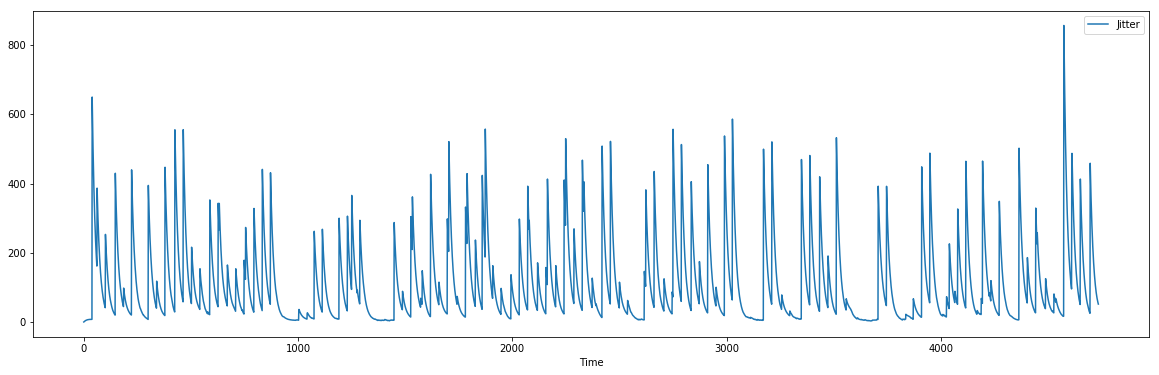

In [25]:
df.plot();

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

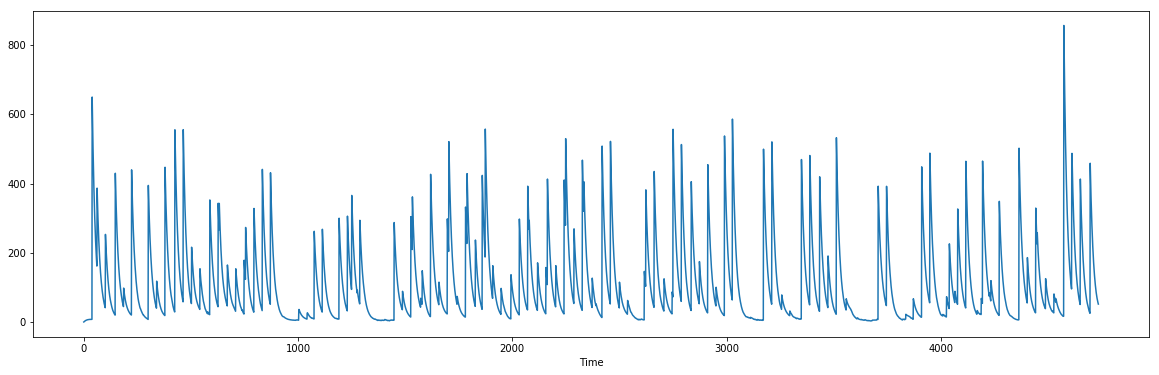

In [9]:
df['Jitter'].plot()

In [27]:
adf_test(df['Jitter'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.438020e+01
p-value                 9.180237e-27
# lags used             7.000000e+00
# observations          4.726000e+03
critical value (1%)    -3.431734e+00
critical value (5%)    -2.862152e+00
critical value (10%)   -2.567096e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [11]:
auto_arima(df['Jitter'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4734
Model:                     ARMA(2, 1)   Log Likelihood              -25001.316
Method:                       css-mle   S.D. of innovations             47.565
Date:                Tue, 08 Sep 2020   AIC                          50012.632
Time:                        09:24:00   BIC                          50044.945
Sample:                             0   HQIC                         50023.989
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.9629      6.483     16.807      0.000      96.256     121.670
ar.L1.y        1.8013      0.048     37.662      0.000       1.708       1.895
ar.L2.y       -0.8141      0.043    -18.944      0.000      -0.898      -0.730
ma.L1.y       -0.8793      0.050    -17.532      0.000      -0.978      -0.781
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1063           -0.0670j            1.1083           -0.0096
AR.2            1.1063           +0.0670j            1.1083            0.0096
MA.1            1.1372           +0.0000j            1.1372            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
auto_arima(df['Jitter'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4734
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -25004.380
Date:                Tue, 08 Sep 2020   AIC                          50014.759
Time:                        11:07:08   BIC                          50034.147
Sample:                             0   HQIC                         50021.573
                               - 4734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.1087      2.370      4.265      0.000       5.463      14.755
ar.L1          0.9073      0.016     57.370      0.000       0.876       0.938
sigma2      2265.4168     21.307    106.324      0.000    2223.656    2307.177
===================================================================================
Ljung-Box (Q):                      405.34   Jarque-Bera (JB):           1519898.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             8.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
len(df) * 0.60

2840.4

In [15]:
train = df.iloc[:2840]
test = df.iloc[2840:]

In [28]:
df.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734],
           dtype='int64', name='Time', length=4734)

In [29]:
model = ARMA(train['Jitter'],order=(2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Jitter   No. Observations:                 2840
Model:                     ARMA(2, 1)   Log Likelihood              -14897.106
Method:                       css-mle   S.D. of innovations             45.888
Date:                Tue, 08 Sep 2020   AIC                          29804.211
Time:                        11:04:33   BIC                          29833.969
Sample:                             0   HQIC                         29814.945
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          110.4573      7.932     13.926      0.000      94.911     126.003
ar.L1.Jitter     1.8186      0.051     35.639      0.000       1.719       1.919
ar.L2.Jitter    -0.8297      0.046    -18.104      0.000      -0.919      -0.740
ma.L1.Jitter    -0.8976      0.054    -16.739      0.000      -1.003      -0.792
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0960           -0.0645j            1.0979           -0.0094
AR.2            1.0960           +0.0645j            1.0979            0.0094
MA.1            1.1141           +0.0000j            1.1141            0.0000
-----------------------------------------------------------------------------
"""

In [189]:
model1 = ARMA(train['Jitter'][:147],order=(2,1))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Jitter   No. Observations:                  147
Model:                     ARMA(2, 1)   Log Likelihood                -807.012
Method:                       css-mle   S.D. of innovations             57.991
Date:                Sat, 12 Sep 2020   AIC                           1624.024
Time:                        08:55:20   BIC                           1638.976
Sample:                             0   HQIC                          1630.099
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          131.7249     22.068      5.969      0.000      88.472     174.978
ar.L1.Jitter     1.9012      0.032     58.565      0.000       1.838       1.965
ar.L2.Jitter    -0.9053      0.033    -27.746      0.000      -0.969      -0.841
ma.L1.Jitter    -1.0000      0.017    -58.395      0.000      -1.034      -0.966
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0501           -0.0444j            1.0510           -0.0067
AR.2            1.0501           +0.0444j            1.0510            0.0067
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [265]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = results.predict(start=start, end=end).rename('ARMA(2,1) Predictions')

In [266]:
arma_pred = predictions1.values[:147]

In [267]:
txt = test['Jitter'].values[:147]

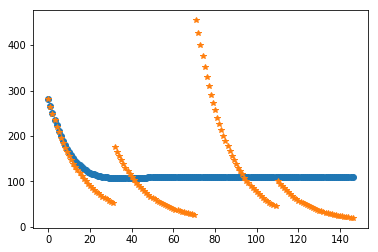

In [268]:
plt.plot(arma_pred,'o')
plt.plot(txt,'*')

In [225]:
arma_pred

array([281.02157589, 264.99995121, 249.9927408 , 235.99366143,
       222.98631429, 210.94609006, 199.8418406 , 189.63733837,
       180.29254363, 171.76469813, 164.00926255, 156.98071417,
       150.6332194 , 144.92119537, 139.79977292, 135.22517294,
       131.15500641, 127.54850794, 124.36671153, 121.57257643,
       119.13107011, 117.00921496, 115.17610413, 113.60289169,
       112.26276168, 111.13087984, 110.18433159, 109.40204928,
       108.76473135, 108.25475565, 107.85608886, 107.55419381,
       107.33593586, 107.18948976, 107.1042478 , 107.07073012,
       107.08049778, 107.12606906, 107.20083942, 107.2990054 ,
       107.4154925 , 107.54588736, 107.68637408, 107.83367479,
       107.98499438, 108.13796928, 108.29062016, 108.44130844,
       108.58869648, 108.73171106, 108.86951033, 109.00145372,
       109.12707472, 109.24605647, 109.35820974, 109.46345328,
       109.56179639, 109.6533233 , 109.73817957, 109.81655995,
       109.88869788, 109.9548563 , 110.01531971, 110.07

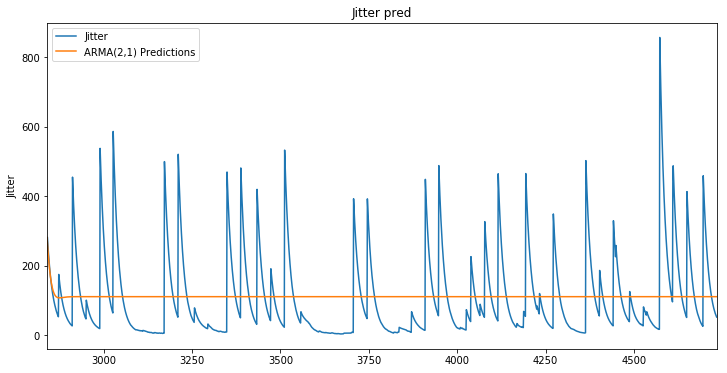

In [31]:
title = 'Jitter pred'
ylabel='Jitter'
xlabel='' # we don't really need a label here

ax = test['Jitter'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [186]:
 from sklearn.metrics import r2_score

In [310]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Jitter'], predictions1)
print(f'ARMA(2,1) RMSE Error: {np.sqrt(error):}')

ARMA(2,1) RMSE Error: 119.15983277958347


In [188]:
error1 = r2_score(test['Jitter'], predictions)
print(f'ARMA(2,1) R^2: {error1:}')

ARMA(2,1) R^2: -0.004081357778020989


In [36]:
model2 = ARIMA(train['Jitter'],order=(2,0,1))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Jitter   No. Observations:                 2840
Model:                     ARMA(2, 1)   Log Likelihood              -14897.106
Method:                       css-mle   S.D. of innovations             45.888
Date:                Tue, 08 Sep 2020   AIC                          29804.211
Time:                        11:14:56   BIC                          29833.969
Sample:                             0   HQIC                         29814.945
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          110.4573      7.932     13.926      0.000      94.911     126.003
ar.L1.Jitter     1.8186      0.051     35.639      0.000       1.719       1.919
ar.L2.Jitter    -0.8297      0.046    -18.104      0.000      -0.919      -0.740
ma.L1.Jitter    -0.8976      0.054    -16.739      0.000      -1.003      -0.792
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0960           -0.0645j            1.0979           -0.0094
AR.2            1.0960           +0.0645j            1.0979            0.0094
MA.1            1.1141           +0.0000j            1.1141            0.0000
-----------------------------------------------------------------------------
"""

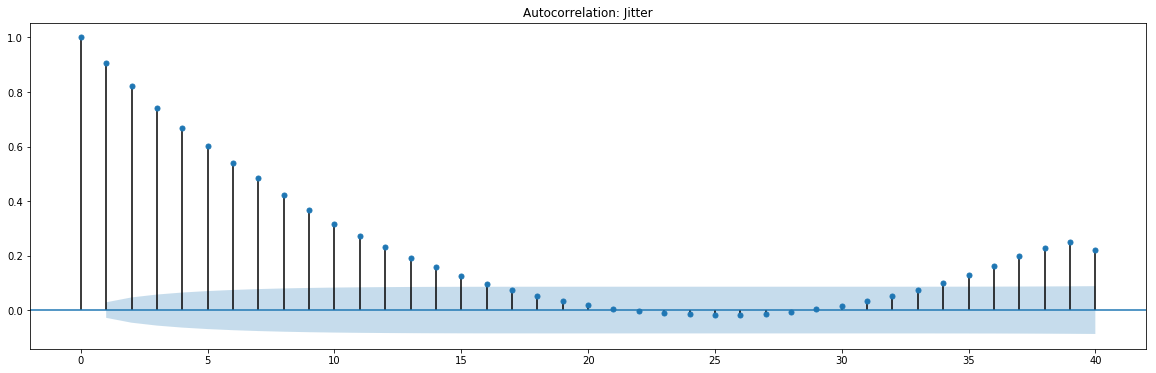

In [37]:
title = 'Autocorrelation: Jitter'
lags = 40
plot_acf(df['Jitter'],title=title,lags=lags);

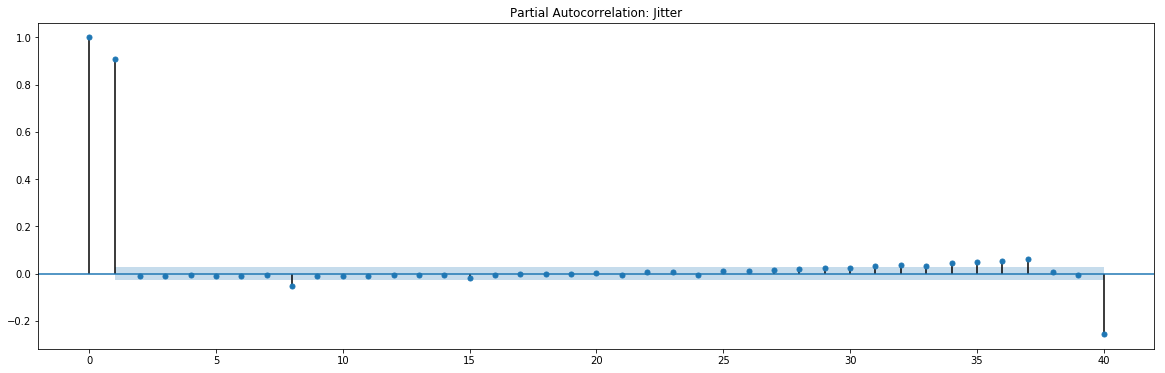

In [38]:
title = 'Partial Autocorrelation: Jitter'
lags = 40
plot_pacf(df['Jitter'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the Duke University Statistical Forecasting site:

If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

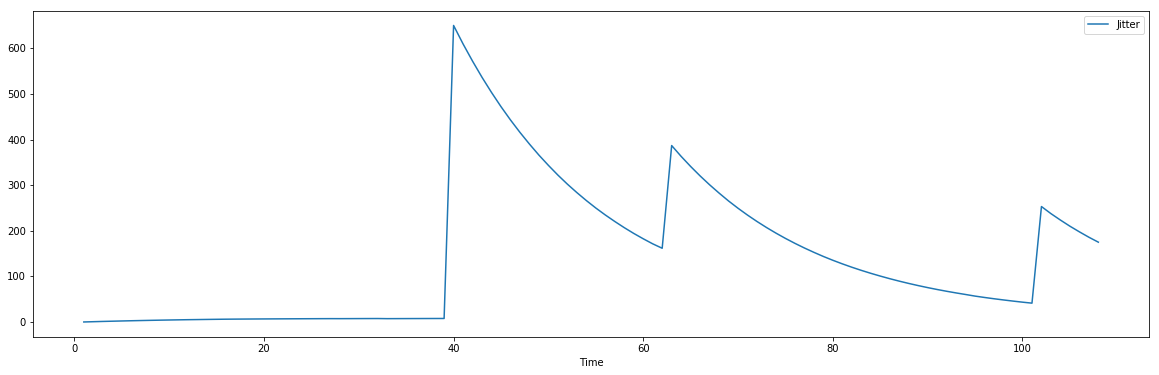

In [40]:
df[:108].plot()

In [41]:
stepwise_fit = auto_arima(df['Jitter'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 0); AIC=58228.298, BIC=58241.223, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0); AIC=50014.757, BIC=50034.145, Fit time=0.134 seconds
Fit ARIMA: order=(0, 0, 1); AIC=54257.824, BIC=54277.211, Fit time=0.159 seconds
Fit ARIMA: order=(2, 0, 0); AIC=50016.194, BIC=50042.044, Fit time=0.217 seconds
Fit ARIMA: order=(1, 0, 1); AIC=50016.204, BIC=50042.054, Fit time=0.641 seconds
Fit ARIMA: order=(2, 0, 1); AIC=50012.632, BIC=50044.945, Fit time=2.173 seconds
Fit ARIMA: order=(2, 0, 2); AIC=50014.365, BIC=50053.140, Fit time=2.914 seconds
Total fit time: 6.250 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4734
Model:                     ARMA(2, 1)   Log Likelihood              -25001.316
Method:                       css-mle   S.D. of innovations             47.565
Date:                Tue, 08 Sep 2020   AIC                          50012.632
Time:                        11:35:42   BIC                          50044.945
Sample:                             0   HQIC                         50023.989
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.9629      6.483     16.807      0.000      96.256     121.670
ar.L1.y        1.8013      0.048     37.662      0.000       1.708       1.895
ar.L2.y       -0.8141      0.043    -18.944      0.000      -0.898      -0.730
ma.L1.y       -0.8793      0.050    -17.532      0.000      -0.978      -0.781
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1063           -0.0670j            1.1083           -0.0096
AR.2            1.1063           +0.0670j            1.1083            0.0096
MA.1            1.1372           +0.0000j            1.1372            0.0000
-----------------------------------------------------------------------------
"""

In [42]:
df_ewma = df.copy()

In [43]:
df_ewma.head()

,Jitter
Time,
1,0.000000
2,0.594313
3,1.178605
4,1.684005
5,2.197755


In [44]:
df_ewma['EWMA'] = df_ewma['Jitter'].ewm(span=39,adjust=False).mean()

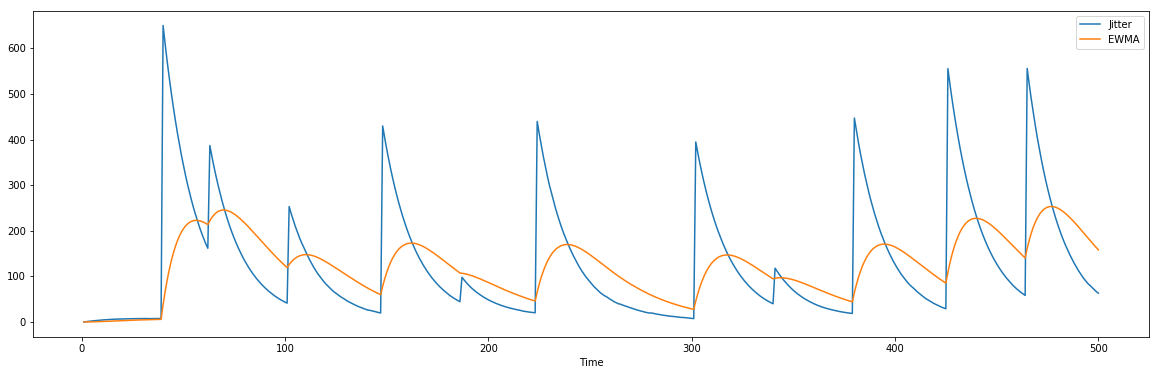

In [47]:
df_ewma[['Jitter','EWMA']][:500].plot();

In [49]:
df_ewma['SMA'] = df_ewma['Jitter'].rolling(window=39).mean()

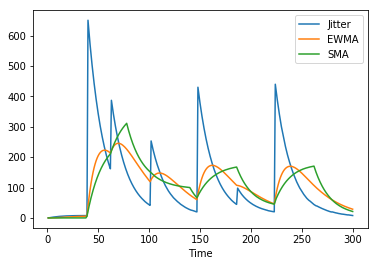

In [153]:
df_ewma[:300].plot();

In [52]:
df.head()

,Jitter
Time,
1,0.000000
2,0.594313
3,1.178605
4,1.684005
5,2.197755


In [54]:
df_lr = df.copy()

In [64]:
x = np.arange(1,len(df_lr)+1)
len(x)

4734

In [65]:
df_lr['x'] = np.arange(1,len(df_lr)+1)

In [66]:
df_lr.head()

,Jitter,x
Time,,
1,0.000000,1
2,0.594313,2
3,1.178605,3
4,1.684005,4
5,2.197755,5


In [67]:
x = df_lr['x']
y = df_lr['Jitter']

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=101)

In [70]:
from sklearn.linear_model import LinearRegression

In [71]:
lm = LinearRegression()

In [73]:
X_train.shape

(2840,)

In [74]:
y_train.shape

(2840,)

In [75]:
type(X_train)

pandas.core.series.Series

In [76]:
xx = np.array(X_train).reshape(-1,1)

In [77]:
xx

array([[3294],
       [2836],
       [3947],
       ...,
       [ 600],
       [1362],
       [1548]])

In [78]:
lm.fit(xx,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
# print the intercept
print(lm.intercept_)

106.95899266006468


In [81]:
xx_test = np.array(X_test).reshape(-1,1)

In [259]:
predictions = lm.predict(xx_test)

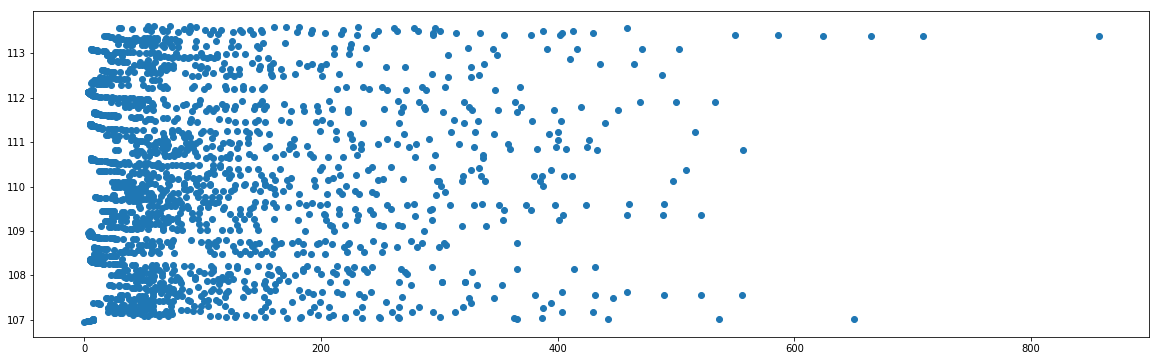

In [83]:
plt.scatter(y_test,predictions)

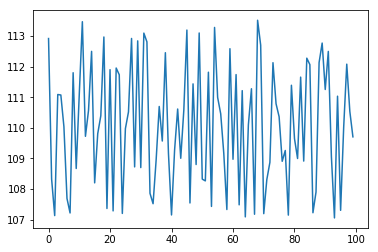

In [262]:
plt.plot(predictions[:100])

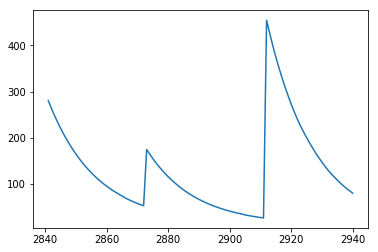

In [270]:
plt.plot(test['Jitter'][:100])

In [271]:
error1 = r2_score(test['Jitter'], predictions)
print(f'ARMA(2,1) R^2: {error1:}')

ARMA(2,1) R^2: 8.456384910382475e-05


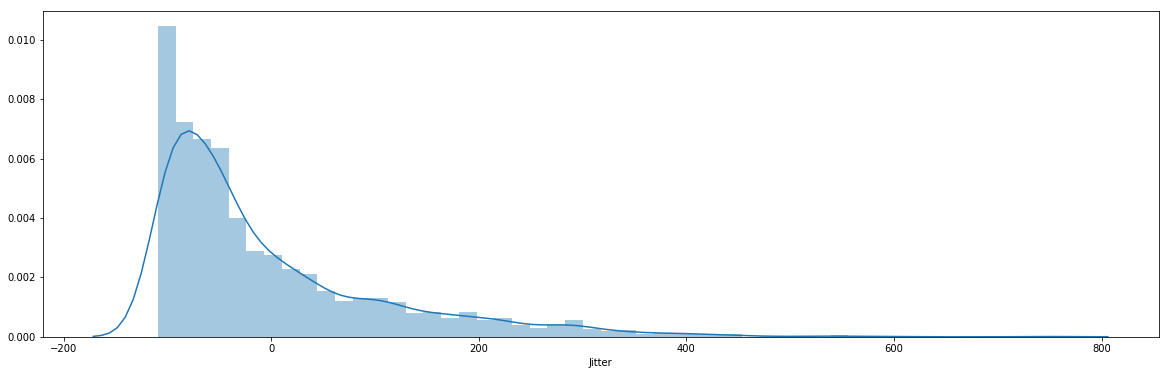

In [88]:
import seaborn as sns
sns.distplot((y_test-predictions),bins=50);

In [85]:
from sklearn import metrics

In [311]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions1))
print('MSE:', metrics.mean_squared_error(y_test, predictions1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions1)))

MAE: 89.75879299828445
MSE: 14199.065748058294
RMSE: 119.15983277958347


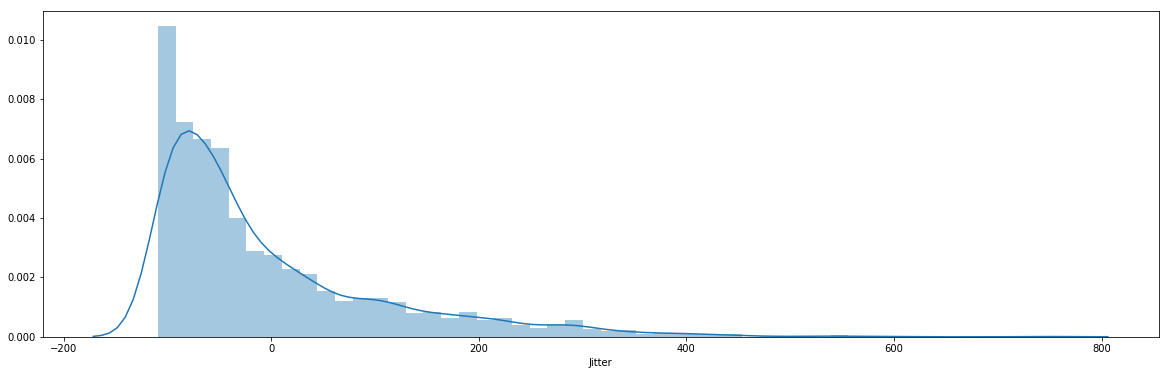

In [89]:
sns.distplot((y_test-predictions),bins=50);

In [93]:
d = lm.intercept_ + df_lr['x'] * lm.coef_

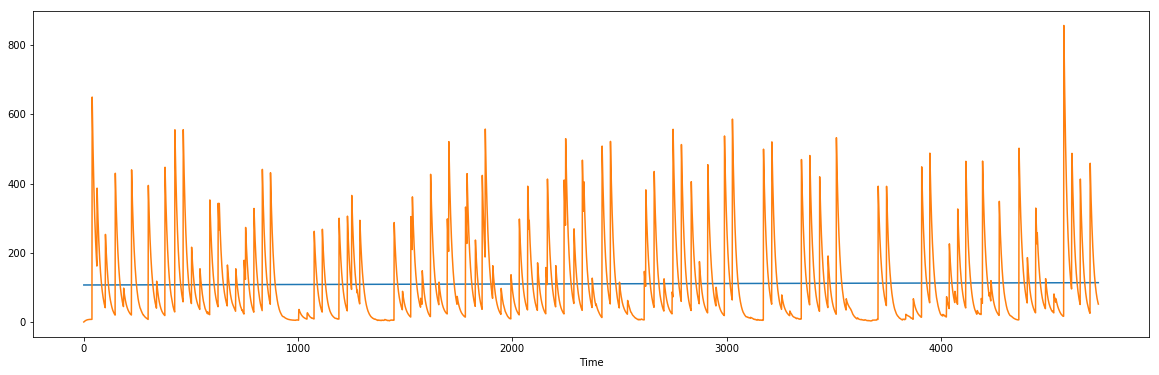

In [95]:
plt.plot(d)
df_lr['Jitter'].plot()

In [96]:
df_lr.head()

,Jitter,x
Time,,
1,0.000000,1
2,0.594313,2
3,1.178605,3
4,1.684005,4
5,2.197755,5


In [97]:
df_stat = df_lr.copy()

In [98]:
import statsmodels.api as sm

In [99]:
df_stat = sm.add_constant(df_stat)

In [100]:
df_stat.head()

,const,Jitter,x
Time,,,
1,1.0,0.000000,1
2,1.0,0.594313,2
3,1.0,1.178605,3
4,1.0,1.684005,4
5,1.0,2.197755,5


In [103]:
res = sm.OLS(df_stat['Jitter'], df_stat[['const', 'x']])
print(res)

In [109]:
print(res.score())

TypeError: score() missing 1 required positional argument: 'params'

In [237]:
arma_pred

array([281.02157589, 264.99995121, 249.9927408 , 235.99366143,
       222.98631429, 210.94609006, 199.8418406 , 189.63733837,
       180.29254363, 171.76469813, 164.00926255, 156.98071417,
       150.6332194 , 144.92119537, 139.79977292, 135.22517294,
       131.15500641, 127.54850794, 124.36671153, 121.57257643,
       119.13107011, 117.00921496, 115.17610413, 113.60289169,
       112.26276168, 111.13087984, 110.18433159, 109.40204928,
       108.76473135, 108.25475565, 107.85608886, 107.55419381,
       107.33593586, 107.18948976, 107.1042478 , 107.07073012,
       107.08049778, 107.12606906, 107.20083942, 107.2990054 ,
       107.4154925 , 107.54588736, 107.68637408, 107.83367479,
       107.98499438, 108.13796928, 108.29062016, 108.44130844,
       108.58869648, 108.73171106, 108.86951033, 109.00145372,
       109.12707472, 109.24605647, 109.35820974, 109.46345328,
       109.56179639, 109.6533233 , 109.73817957, 109.81655995,
       109.88869788, 109.9548563 , 110.01531971, 110.07

In [112]:
predictions[:10]

array([112.916229  , 108.32627335, 107.13201275, 111.08756141,
       111.07208807, 110.03678088, 107.69186636, 107.21781946,
       111.79933511, 108.67090686])

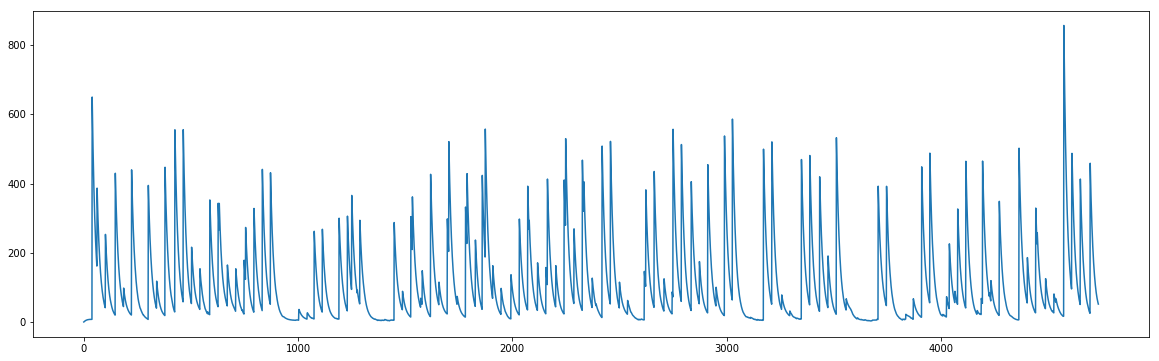

In [115]:
X = df_lr['x'].values
Y = df_lr['Jitter'].values
plt.plot(X,Y)

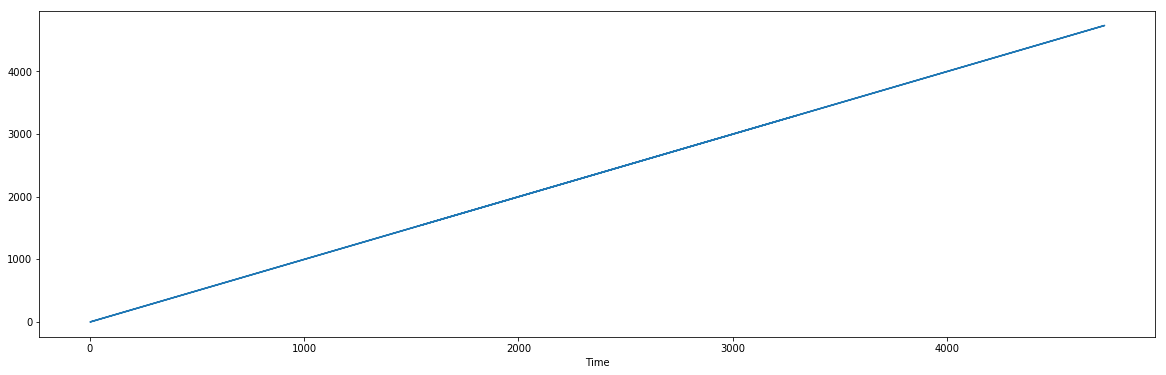

In [118]:
X_train.plot()

In [125]:
len(X)

4734

In [127]:
x_train =X[:2840]
x_test = X[2840:]
y_train = Y[:2840]
y_test = Y[2840:]

In [129]:
lr = LinearRegression()

In [131]:
lr.fit(x_train.reshape(-1,1),y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [132]:
predictions = lr.predict(xx_test)

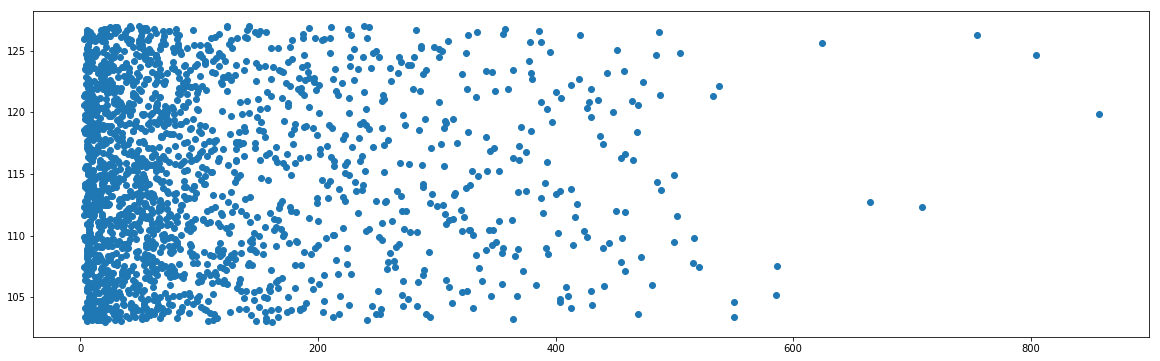

In [133]:
plt.scatter(y_test,predictions)

In [134]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 91.9173051201426
MSE: 14318.546706059971
RMSE: 119.66012997678037


In [135]:
df_ewma.head()

,Jitter,EWMA,SMA
Time,,,
1,0.000000,0.000000,NaN
2,0.594313,0.029716,NaN
3,1.178605,0.087160,NaN
4,1.684005,0.167002,NaN
5,2.197755,0.268540,NaN


In [164]:
eva_df = df_ewma[:147]

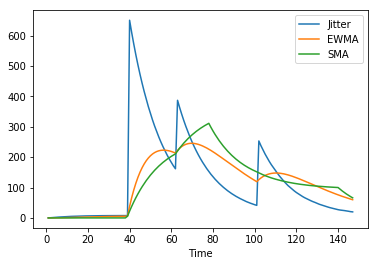

In [165]:
eva_df.plot()

In [226]:
eva_df_arma = eva_df.copy()

In [238]:
arma_arr = np.array([281.02157589, 264.99995121, 249.9927408 , 235.99366143,
       222.98631429, 210.94609006, 199.8418406 , 189.63733837,
       180.29254363, 171.76469813, 164.00926255, 156.98071417,
       150.6332194 , 144.92119537, 139.79977292, 135.22517294,
       131.15500641, 127.54850794, 124.36671153, 121.57257643,
       119.13107011, 117.00921496, 115.17610413, 113.60289169,
       112.26276168, 111.13087984, 110.18433159, 109.40204928,
       108.76473135, 108.25475565, 107.85608886, 107.55419381,
       107.33593586, 107.18948976, 107.1042478 , 107.07073012,
       107.08049778, 107.12606906, 107.20083942, 107.2990054 ,
       107.4154925 , 107.54588736, 107.68637408, 107.83367479,
       107.98499438, 108.13796928, 108.29062016, 108.44130844,
       108.58869648, 108.73171106, 108.86951033, 109.00145372,
       109.12707472, 109.24605647, 109.35820974, 109.46345328,
       109.56179639, 109.6533233 , 109.73817957, 109.81655995,
       109.88869788, 109.9548563 , 110.01531971, 110.07038732,
       110.12036726, 110.16557161, 110.2063123 , 110.24289763,
       110.27562949, 110.30480112, 110.33069529, 110.35358299,
       110.37372239, 110.39135818, 110.40672115, 110.42002801,
       110.43148134, 110.4412698 , 110.44956837, 110.45653878,
       110.46232992, 110.46707841, 110.47090918, 110.47393605,
       110.47626237, 110.47798166, 110.47917825, 110.4799279 ,
       110.48029843, 110.4803503 , 110.48013722, 110.47970669,
       110.47910052, 110.47835536, 110.47750316, 110.4765716 ,
       110.47558453, 110.47456237, 110.47352244, 110.47247929,
       110.47144506, 110.4704297 , 110.46944126, 110.46848612,
       110.4675692 , 110.46669418, 110.46586362, 110.46507917,
       110.46434167, 110.46365131, 110.46300772, 110.46241007,
       110.46185718, 110.46134754, 110.46087945, 110.46045103,
       110.46006026, 110.45970508, 110.45938335, 110.45909296,
       110.45883178, 110.45859774, 110.45838882, 110.45820304,
       110.45803854, 110.4578935 , 110.45776623, 110.45765511,
       110.45755863, 110.45747535, 110.45740396, 110.45734321,
       110.45729198, 110.45724921, 110.45721394, 110.45718527,
       110.4571624 , 110.4571446 , 110.4571312 , 110.45712159,
       110.45711525, 110.45711168, 110.45711046, 110.45711119,
       110.45711353, 110.45711719, 110.45712189])

In [239]:
len(arma_arr)

147

In [240]:
len(eva_df_arma)

147

In [241]:
eva_df_arma['arma'] = arma_arr

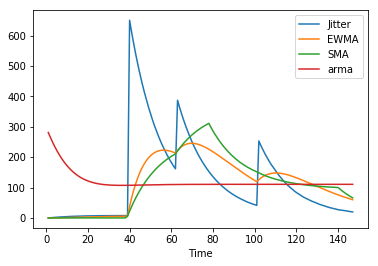

In [243]:
eva_df_arma.plot()

In [ ]:
error1 = r2_score(test['Jitter'], predictions)
print(f'ARMA(2,1) R^2: {error1:}')

In [300]:
print('MAE:', metrics.mean_absolute_error(eva_df['Jitter'], eva_df['EWMA']))
print('MSE:', metrics.mean_squared_error(eva_df['Jitter'], eva_df['EWMA']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(eva_df['Jitter'], eva_df['EWMA'])))
print('R^2:', r2_score(eva_df['Jitter'], eva_df['EWMA']))

MAE: 65.49638211653571
MSE: 13418.377258438966
RMSE: 115.83771949774808
R^2: 0.31921910939968


In [149]:
eva_df.fillna(0, inplace=True)

In [150]:
eva_df.head()

,Jitter,EWMA,SMA
Time,,,
1,0.000000,0.000000,0.0
2,0.594313,0.029716,0.0
3,1.178605,0.087160,0.0
4,1.684005,0.167002,0.0
5,2.197755,0.268540,0.0


In [301]:
print('MAE:', metrics.mean_absolute_error(eva_df['Jitter'], eva_df['SMA']))
print('MSE:', metrics.mean_squared_error(eva_df['Jitter'], eva_df['SMA']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(eva_df['Jitter'], eva_df['SMA'])))
print('R^2:', r2_score(eva_df['Jitter'], eva_df['SMA']))

MAE: 81.23553675070535
MSE: 18193.676377068856
RMSE: 134.88393669028517
R^2: 0.0769444792972036


R^2: 0.0769444792972036


In [275]:
8.456384910382475e-05

8.456384910382475e-05

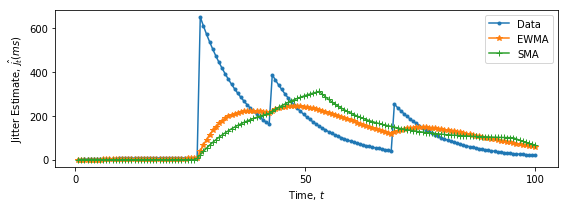

In [184]:
fig, axe = plt.subplots(figsize=(8,3))
axe.plot(eva_df['Jitter'], label='Data', ls='-', marker='.')
axe.plot(eva_df['EWMA'],ls='-', marker='*')
axe.plot(eva_df['SMA'],ls='-', marker='+')

l = [0, 73.5, 147]
lx = ['0', '50', '100']
axe.set_xticks(l)
axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
axe.legend()
fig.tight_layout()
fig.savefig('other_models.pdf', format='pdf', dpi=2500);
#axe.grid()

In [167]:
140/6

23.333333333333332

In [174]:
len(l)

2

In [170]:
140/7

20.0

In [172]:
140/20

7.0

In [247]:
fit = np.array([466.87439074, 437.96603127, 411.1953727 , 385.97146696,
       362.44996697, 340.29690102, 319.54071057, 300.34124172,
       282.17254521, 264.82705592, 248.64814388, 233.46138319,
       219.21502998, 205.93930145, 193.42791913, 181.86236679,
       170.84758495, 160.70343939, 151.09368511, 142.18249232,
       133.83008798, 125.89441774, 118.79401397])

In [250]:
eva_df['Jitter'][39:62].values


array([650.2120319, 609.6619535, 571.9492203, 536.4599426, 503.3212726,
       472.1334361, 443.0139852, 415.7232848, 390.1294684, 365.9167447,
       343.433587 , 322.1317239, 302.2658523, 283.7633129, 266.2925989,
       249.8895476, 234.6623398, 220.3889574, 206.8540781, 194.1904344,
       182.4447336, 171.3749864, 161.6639733])

In [254]:
eva_df['Jitter'][62:101].values

array([386.859093  , 363.1057122 , 341.013751  , 320.2696555 ,
       300.8559479 , 282.658347  , 265.3412211 , 249.3604781 ,
       234.3815941 , 220.3387028 , 207.1730477 , 194.8310656 ,
       183.2602698 , 172.4127113 , 162.2431877 , 152.7092593 ,
       143.6598195 , 135.2843516 , 127.4347254 , 120.0760134 ,
       113.1775334 , 106.7099584 , 100.6459124 ,  94.92368177,
        89.5520211 ,  84.51545728,  79.79443565,  75.36835286,
        71.21896275,  67.32890953,  63.68192213,  60.26274644,
        56.72601923,  53.73452497,  50.91843661,  48.29522182,
        45.8021524 ,  43.44271232,  41.28436224])

In [255]:
j_62_101 = np.array([386.859093  , 363.1057122 , 341.013751  , 320.2696555 ,
       300.8559479 , 282.658347  , 265.3412211 , 249.3604781 ,
       234.3815941 , 220.3387028 , 207.1730477 , 194.8310656 ,
       183.2602698 , 172.4127113 , 162.2431877 , 152.7092593 ,
       143.6598195 , 135.2843516 , 127.4347254 , 120.0760134 ,
       113.1775334 , 106.7099584 , 100.6459124 ,  94.92368177,
        89.5520211 ,  84.51545728,  79.79443565,  75.36835286,
        71.21896275,  67.32890953,  63.68192213,  60.26274644,
        56.72601923,  53.73452497,  50.91843661,  48.29522182,
        45.8021524 ,  43.44271232,  41.28436224])

In [257]:
j_62_101[:23]

array([386.859093 , 363.1057122, 341.013751 , 320.2696555, 300.8559479,
       282.658347 , 265.3412211, 249.3604781, 234.3815941, 220.3387028,
       207.1730477, 194.8310656, 183.2602698, 172.4127113, 162.2431877,
       152.7092593, 143.6598195, 135.2843516, 127.4347254, 120.0760134,
       113.1775334, 106.7099584, 100.6459124])

In [251]:
j_39_62 = np.array([650.2120319, 609.6619535, 571.9492203, 536.4599426, 503.3212726,
       472.1334361, 443.0139852, 415.7232848, 390.1294684, 365.9167447,
       343.433587 , 322.1317239, 302.2658523, 283.7633129, 266.2925989,
       249.8895476, 234.6623398, 220.3889574, 206.8540781, 194.1904344,
       182.4447336, 171.3749864, 161.6639733])

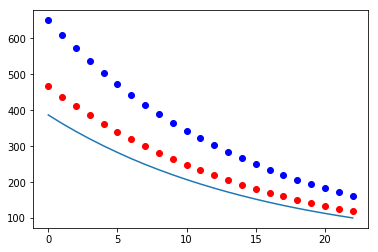

In [258]:
plt.plot(fit,'ro')
plt.plot(j_39_62,'bo')
plt.plot(j_62_101[:23])

In [280]:
-0.00408 == -4.08e-3

True

In [278]:
-0.00408

-0.00408

In [281]:
eva_df.head()

,Jitter,EWMA,SMA
Time,,,
1,0.000000,0.000000,0.0
2,0.594313,0.029716,0.0
3,1.178605,0.087160,0.0
4,1.684005,0.167002,0.0
5,2.197755,0.268540,0.0


In [295]:
#compute the sma and ewma with half period estimates
eva_df2 = df[:147]

In [296]:
eva_df2.head()

,Jitter
Time,
1,0.000000
2,0.594313
3,1.178605
4,1.684005
5,2.197755


In [297]:
eva_df2['EWMA'] = eva_df2['Jitter'].ewm(span=19,adjust=False).mean()

In [298]:
eva_df2['SMA'] = eva_df2['Jitter'].rolling(window=19).mean()

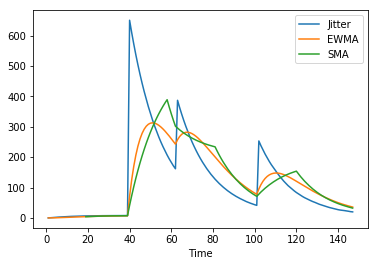

In [299]:
eva_df2.plot()

In [305]:
print('MAE:', metrics.mean_absolute_error(eva_df2['Jitter'], eva_df2['EWMA']))
print('MSE:', metrics.mean_squared_error(eva_df2['Jitter'], eva_df2['EWMA']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(eva_df2['Jitter'], eva_df2['EWMA'])))
print('R^2:', r2_score(eva_df2['Jitter'], eva_df2['EWMA']))

MAE: 49.48196656986199
MSE: 8782.488479797144
RMSE: 93.7149320001735
R^2: 0.5544207608857381


In [307]:
eva_df2.fillna(0,inplace=True)

In [308]:
print('MAE:', metrics.mean_absolute_error(eva_df2['Jitter'], eva_df2['SMA']))
print('MSE:', metrics.mean_squared_error(eva_df2['Jitter'], eva_df2['SMA']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(eva_df2['Jitter'], eva_df2['SMA'])))
print('R^2:', r2_score(eva_df2['Jitter'], eva_df2['SMA']))

MAE: 62.413602416490136
MSE: 12805.299633839677
RMSE: 113.16050385995848
R^2: 0.3503235807707873


## SARIMA

In [303]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

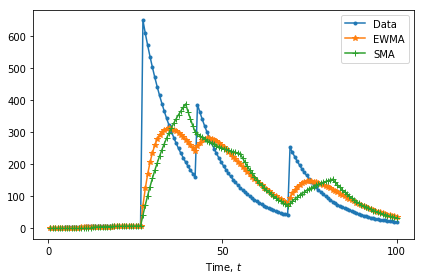

In [323]:
fig, axe = plt.subplots(figsize=(6,4))
axe.plot(eva_df2['Jitter'], label='Data', marker='.')
axe.plot(eva_df2['EWMA'],ls='-', marker='*')
axe.plot(eva_df2['SMA'],ls='-', marker='+')

l = [0, 73.5, 147]
lx = ['0', '50', '100']
axe.set_xticks(l)
axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
axe.legend()
fig.tight_layout()
#fig.savefig('other1.pdf', format='pdf', dpi=2500);
#axe.grid()

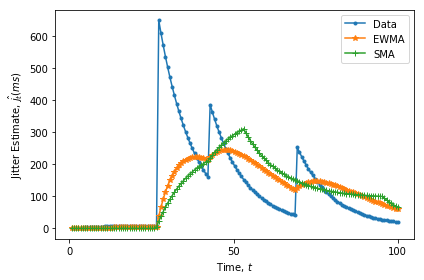

In [324]:
fig, axe = plt.subplots(figsize=(6,4))
axe.plot(eva_df['Jitter'], label='Data', ls='-', marker='.')
axe.plot(eva_df['EWMA'],ls='-', marker='*')
axe.plot(eva_df['SMA'],ls='-', marker='+')

l = [0, 73.5, 147]
lx = ['0', '50', '100']
axe.set_xticks(l)
axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
axe.legend()
fig.tight_layout()
fig.savefig('other.pdf', format='pdf', dpi=2500);
#axe.grid()

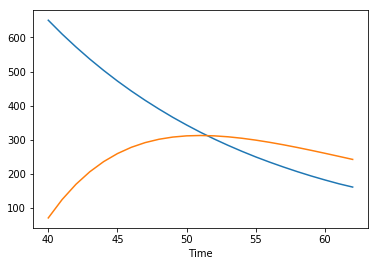

In [326]:
eva_df2['Jitter'][39:62].plot()
eva_df2['EWMA'][39:62].plot()

In [327]:
115.84 - 93.71

22.13000000000001

In [329]:
(22.13/115.84)*100

19.1039364640884

In [330]:
134.88 - 113.16

21.72

In [331]:
(21.72/138.88)*100

15.639400921658986

In [ ]:
plt.plot(fit,'ro')
plt.plot(j_39_62,'bo')
plt.plot(j_62_101[:23])

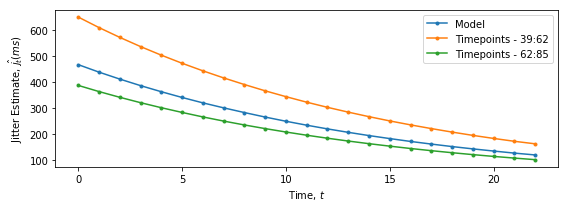

In [340]:
fig, axe = plt.subplots(figsize=(8,3))
axe.plot(fit, label='Model', ls='-', marker='.')
axe.plot(j_39_62, label='Timepoints - 39:62', ls='-', marker='.')
axe.plot(j_62_101[:23], label='Timepoints - 62:85', ls='-', marker='.')

#l = [0, 73.5, 147]
#lx = ['0', '50', '100']
#axe.set_xticks(l)
#axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
axe.legend()
fig.tight_layout()
fig.savefig('model_datapoints.pdf', format='pdf', dpi=2500);
#axe.grid()

In [335]:
62+23

85